In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from bokeh.plotting import *
output_notebook()
%load_ext autoreload
%autoreload 2
from getGaiaData import GaiaClusterMembers
import hdbscan

Loading BokehJS ...

Directory exists.
Prior distance =  1957.392860875564  pc


Search radius for HDBSCAN? (in degrees) .5
Min cluster size? 10


4627  members in group  -1
13  members in group  0
10  members in group  1
10  members in group  2
14  members in group  3
11  members in group  4
15  members in group  5
34  members in group  6
13  members in group  7
1402  members in group  8
19  members in group  9


Which group? 8


Cluster distance =  1889.4100172106491  pc


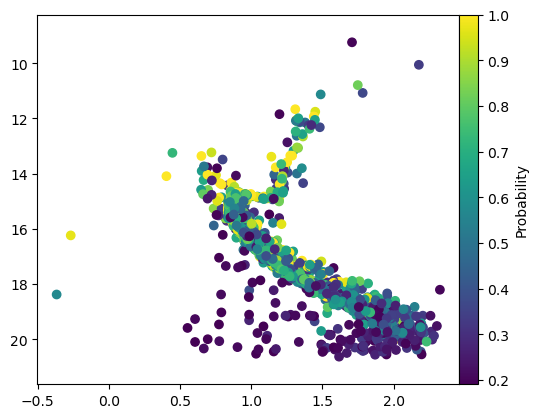

Use this group? (y/n)? y


Parameter('stddev', value=1.636437227208249, bounds=(1.1754943508222875e-38, None)) 9.204556888229583


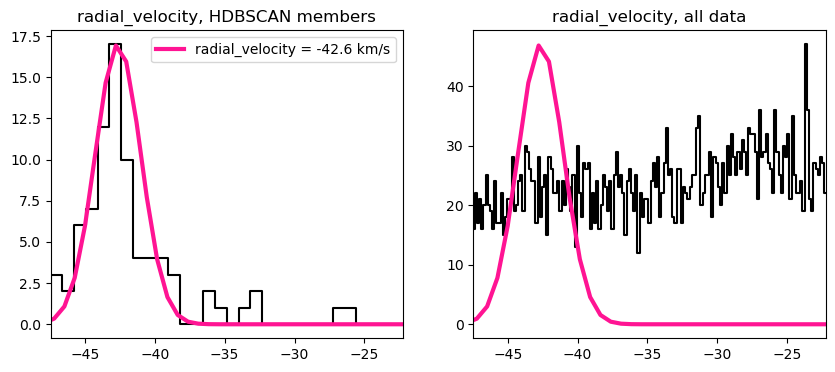

Parameter('stddev', value=144.2747010868139, bounds=(1.1754943508222875e-38, None)) 323.8697470128723


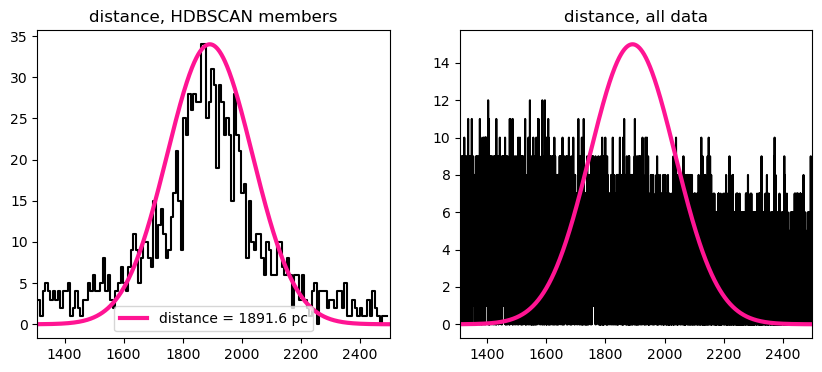

Parameter('stddev', value=0.1138693589970159, bounds=(1.1754943508222875e-38, None)) 0.2891281918091946


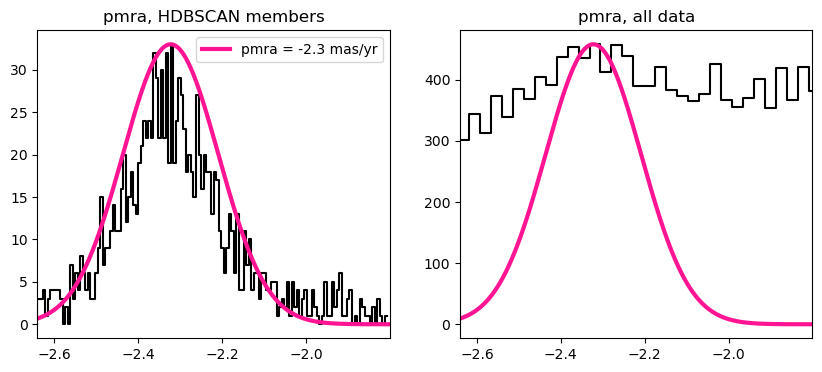

Parameter('stddev', value=0.13684793684067206, bounds=(1.1754943508222875e-38, None)) 0.35214757702503185


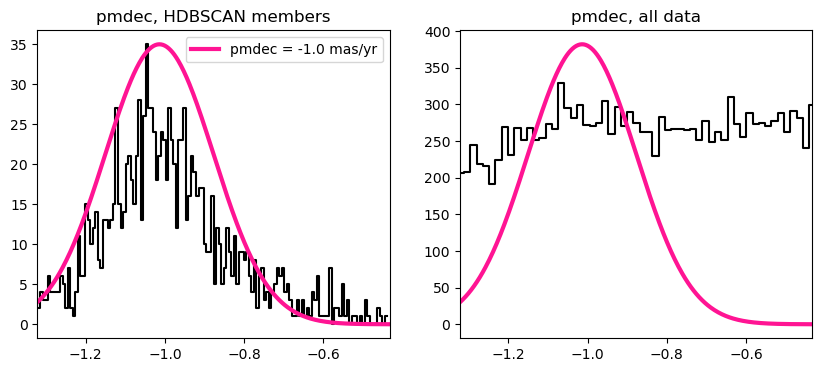

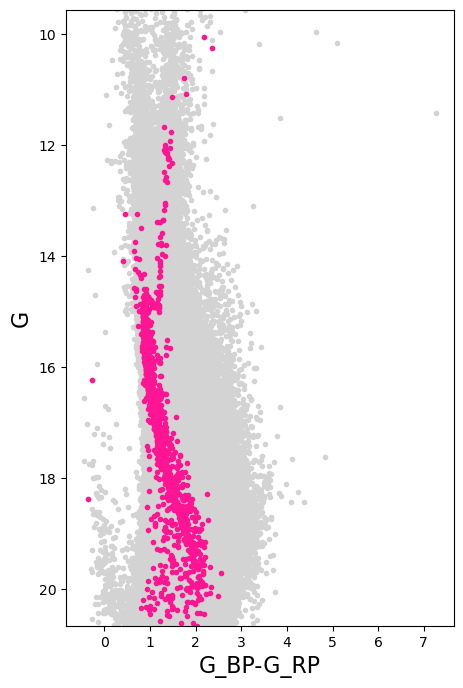

Length of members =  1512
fit parameters :
amplitude = 12.1 +/- 1.29
r_core = 4.41 +/- 0.365
r_tide = 46.9 +/- 1.73


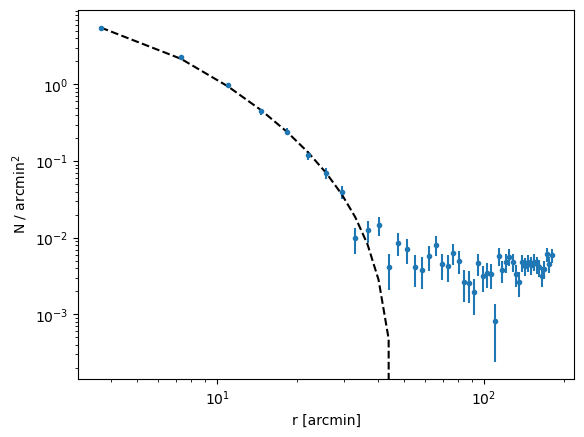

done.


In [2]:
Hunt = pd.read_csv('Hunt2023.tsv',sep='\s+', header=94)

def distance_modulus_to_pc(distance_modulus):
    return 10 ** ((distance_modulus + 5) / 5)

def run_pipeline(clusterName,query=False):
    cluster = GaiaClusterMembers()
    pwd = 'OC_data/'+clusterName+'_dir'
    if os.path.isdir(pwd):
        print("Directory exists.")
    else:
        os.makedirs(pwd)
        os.makedirs(pwd+'/plots')
    cluster.plotNameRoot = pwd+'/plots/'
    cluster.photOutputFileName = pwd +'/'+clusterName + '.phot'
    cluster.saveDataFile = pwd +'/'+clusterName + '.csv'
    cluster.yamlOutputFileName = pwd + '/base9.yaml'
    cluster.yamlTemplateFileName = 'template_base9.yaml'
    
    Hunt_data = Hunt[Hunt['Name']==clusterName]
    cluster.rt = Hunt_data['rt'].values[0]
    Av = round(Hunt_data['AV50'].values[0],5)
    err_Av = round(Hunt_data['AV84'].values[0],5)
    logAge = round(Hunt_data['logAge50'].values[0],5)
    dmod = round(Hunt_data['MOD50'].values[0],5)
    prior_pc = distance_modulus_to_pc(dmod)
    err_dmod = round(Hunt_data['MOD50'].values[0]-Hunt_data['MOD16'].values[0],5)
    start_dmod = dmod
    start_FeH = 0
    start_Av = Av
    start_age = logAge
    cluster.yamlInputDict = {
    'photFile' : clusterName + '.phot',
    'outputFileBase' : clusterName,
    'modelDirectory' : '/projects/p31721/BASE9/base-models/',
    'msRgbModel' : 5,
    'Fe_H' : [start_FeH, 0.0, 0.3, 0.3],
    'Av' : [start_Av, Av, err_Av, 0.3],
    'Y' : [0.29, 0.29, 0.0], # keep the defaults
    'carbonicity' : [0.38, 0.38, 0.0], # keep the defaults
    'logAge' : [start_age, logAge, np.inf],
    'distMod' : [start_dmod, dmod, err_dmod],
    }
    
    if query:
        cluster.radius = float(input("What radius to query from Gaia? (Deg)"))
        cluster.query_data(clusterName,pwd+'/'+clusterName+'_GaiaData.ecsv') #run this line to download Gaia data that will be saved to the file clusterName+'_dir/'+clusterName+'_GaiaData.ecsv'
    else:
        prior_pc = distance_modulus_to_pc(dmod)
        print ("Prior distance = ",prior_pc," pc") #I show this as a check that I am looking at the right OC
        cluster.runAll(clusterName,filename='ecsv_data/'+clusterName+'_GaiaData.ecsv') #run this line if Gaia data has already been downloaded  
        cluster.photOutputFileName = pwd +'/'+clusterName + '_sig1.phot'
        layout = cluster.createInteractiveIsochrone('PARSEC.model', 
                                                    initialGuess = [
                                                        float(cluster.yamlInputDict['logAge'][0]), 
                                                        float(cluster.yamlInputDict['Fe_H'][0]),
                                                        float(cluster.yamlInputDict['distMod'][0]),
                                                        float(cluster.yamlInputDict['Av'][0])
                                                    ],
                                           mag ='phot_g_mean_mag', color1 ='phot_bp_mean_mag', color2 ='phot_rp_mean_mag', xrng = [-4,4], yrng = [24,5])
        # in order to run a Python callback in a Jupyter notbook, you need to include the following
        def bkapp(doc):
            doc.add_root(layout)
            
        show(bkapp)
run_pipeline('NGC_188', query=False)